In [95]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

In [2]:
with open('input.txt','r') as f:
    data = [int(line.strip()) for line in f if line]

In [41]:
def count_gaps(data):
    data.sort()
    xv = np.array(data)
    diffs = pd.Series(np.diff(xv, 1))
    diffs = pd.Series([*diffs, diffs.min(), diffs.max()]) # account for outlet and wall
    vcs = diffs.value_counts()
    return vcs

In [42]:
vcs = count_gaps(data)
print(vcs)
vcs[1] * vcs[3]

1    75
3    40
dtype: int64


3000

In [38]:
test_case1 = [int(line.strip()) for line in """
16
10
15
5
1
11
7
19
6
12
4
""".split() if line]

test_case2 = [int(line.strip()) for line in """
28
33
18
42
31
14
46
20
48
47
24
23
49
45
19
38
39
11
1
32
25
35
8
17
7
9
4
2
34
10
3
""".split() if line]
#test_cases

In [43]:
vcs = count_gaps(test_case1)
print(vcs)
vcs[1] * vcs[3]

1    7
3    5
dtype: int64


35

In [44]:
vcs = count_gaps(test_case2)
print(vcs)
vcs[1] * vcs[3]

1    22
3    10
dtype: int64


220

# Part 2

Methodology: build a ~~tree~~ DAG where each node is an adapter, and an edge denotes a potential transition to a following adapter.

    >> THIS WILL NOT BE A TREE
    
Take the cumulative products of candidate children along each traversal to get a markovian score for each node for the number of possible paths that could lead up to it. From that point, it doesn't matter which path we're on it, is a valid prefix. 

... the question is essentially, given the transition matrix, how many paths are there from the source to the target? 

I think an efficient way to calculate this will be to sum the powers of the transition matrix until we have gone past the length of diameter of the graph.

...Or more simply: https://networkx.org/documentation/latest/reference/algorithms/generated/networkx.algorithms.simple_paths.all_simple_paths.html#networkx.algorithms.simple_paths.all_simple_paths

In [130]:
# Meh, I like my way enough. Let's not even construct the graph object, just go straight to the transition matrix. 
# For the windowing function, I can just make a dense vector with 1's at indices where we have adaptors, and shift 
# it by the length of the lag I'm testing.

# account for source and sink directly in data
data2 = [*data, 0, max(data)+3]
data2.sort()
idx = np.array(data2)
n = max(data2)+1
s_xv = pd.Series(np.zeros(n))
s_xv.iloc[idx] = 1

In [131]:
s_xv.sum() == len(data2)

True

In [135]:
s_xv.shape, max(data2)

((196,), 195)

In [128]:
max(data), max(data2)

(192, 195)

In [158]:
adj = np.zeros((n,n))

shifts = (1,2,3)
for s in shifts:
    i = s_xv[:-s]
    j = s_xv[s:]
    v = i.values*j.values
    adj[i.index, j.index] += v

adj = (1*(adj > 0)).astype(np.int64)

In [136]:
adj.shape

(196, 196)

In [117]:
# sanity check: no row should have more than 3 positive values
adj.sum(axis=0).max()

3

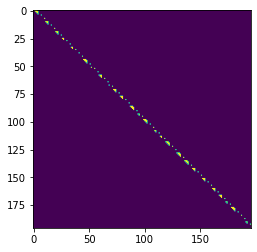

In [159]:
plt.imshow(adj)

In [160]:
adj[:,-1]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
      dtype=int64)

In [161]:
adj.sum()

189

In [162]:
adj2 = copy.deepcopy(adj)
n_paths = copy.deepcopy(adj)
i=0
#while adj2.sum() > 0:
#while True:
for _ in range(len(data2)):
    i+=1
    #adj2 = adj2@adj
    adj2 = adj @ adj2
    #if adj3.sum() > 0:
    #    adj2 = copy.deepcopy(adj3)
    n_paths += adj2
    print(i, n_paths[0,-1])
    #else:
    #    break
    
print(i) 
# err..... yeah, that would be a 115 step path, sounds right
# Oh man, we only make it to 44 steps now... interesting.

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 6561
74 223074
75 3704778
76 40061466
77 317236014
78 1961810442
79 9867225438
80 41511567042
81 149108438520
82 464559834438
83 1271285193222
84 3087456285006
85 6713358857424
86 13171205090610
87 23481571185906
88 38296037379690
89 57513985085851
90 80079266818196
91 104108815130336
92 127350060731476
93 147787038314496
94 164134842447516
95 176031977402656
96 183906658617836
97 188643688604741
98 191230313707222
99 192510184878990
100 193082730922494
101 193313614062832
102 193397234214530
103 193424309577338
104 193432102655674
105 193434082522248
106 193434522559566
107 193434607155874
108 193434621018278
109 193434622916882
110 1934

In [163]:
npaths = np.int64(0)
for k in range(1, len(data2) + 1):
    adjk = np.linalg.matrix_power(adj,k)
    #npaths += adjk[0,-1] 
    #npaths += np.max([0, adjk[0,-1]]) # if we get a negative value for some reason, just ignore it.
    npaths += np.abs(adjk[0,-1])  # uh... maybe we just pretend those negatives are positive?
    print(k, adjk[0,-1], npaths)

1 0 0
2 0 0
3 0 0
4 0 0
5 0 0
6 0 0
7 0 0
8 0 0
9 0 0
10 0 0
11 0 0
12 0 0
13 0 0
14 0 0
15 0 0
16 0 0
17 0 0
18 0 0
19 0 0
20 0 0
21 0 0
22 0 0
23 0 0
24 0 0
25 0 0
26 0 0
27 0 0
28 0 0
29 0 0
30 0 0
31 0 0
32 0 0
33 0 0
34 0 0
35 0 0
36 0 0
37 0 0
38 0 0
39 0 0
40 0 0
41 0 0
42 0 0
43 0 0
44 0 0
45 0 0
46 0 0
47 0 0
48 0 0
49 0 0
50 0 0
51 0 0
52 0 0
53 0 0
54 0 0
55 0 0
56 0 0
57 0 0
58 0 0
59 0 0
60 0 0
61 0 0
62 0 0
63 0 0
64 0 0
65 0 0
66 0 0
67 0 0
68 0 0
69 0 0
70 0 0
71 0 0
72 0 0
73 0 0
74 6561 6561
75 216513 223074
76 3481704 3704778
77 36356688 40061466
78 277174548 317236014
79 1644574428 1961810442
80 7905414996 9867225438
81 31644341604 41511567042
82 107596871478 149108438520
83 315451395918 464559834438
84 806725358784 1271285193222
85 1816171091784 3087456285006
86 3625902572418 6713358857424
87 6457846233186 13171205090610
88 10310366095296 23481571185906
89 14814466193784 38296037379690
90 19217947706161 57513985085851
91 22565281732345 80079266818196
92 24029548312

In [ ]:
# 10770972672 # too low
# 21910088137 # still too low
# 193434623148032 Correct!

# My version way faster than calling np.linalg.matrix_power 
# (probably because I'm implicitly memoizing the intermediate results of the linalg operation)